<a href="https://colab.research.google.com/github/akshara-akkaladevi/SRISHTI_ML_Lab/blob/main/SRISHTI'23_Tutorial_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRISHTI'23 - Tutorial 07
## Introduction to Gradient Descent
#### Lab Coordinator: Shantanu Agrawal

In this lab session, we will try to understand about the **Gradient Descent** and some of the properties related to it as well. But before moving further, please look at the [Tutorial 6 notebook](https://colab.research.google.com/drive/113mi94ko2R1iy_st2v7tR1JRMHvXwfLC) to revisit the concepts of Linear Classifiers and Perceptron Learning Algorithms.

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is

*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$
Here, $\eta$ is learning rate and $\Delta J$ is the gradient of the weight as per the loss function.

Let's try to implement the gradient descent algorithm and undersatnd it simultaneoulsy in this lab.

In [ ]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random   

random.seed(42)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [ ]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

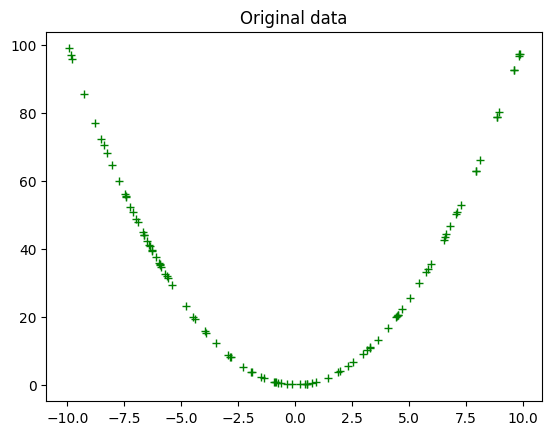

In [ ]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [ ]:
def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].
    
    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.
    
    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.
    
    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max 
    
    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it 
                                                  # give a number greater than the interval min. 
    
    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


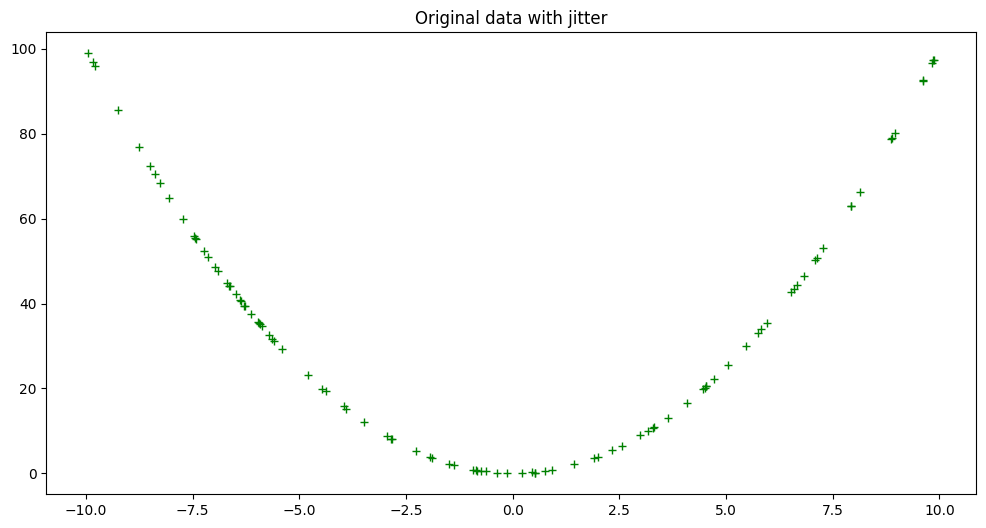

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

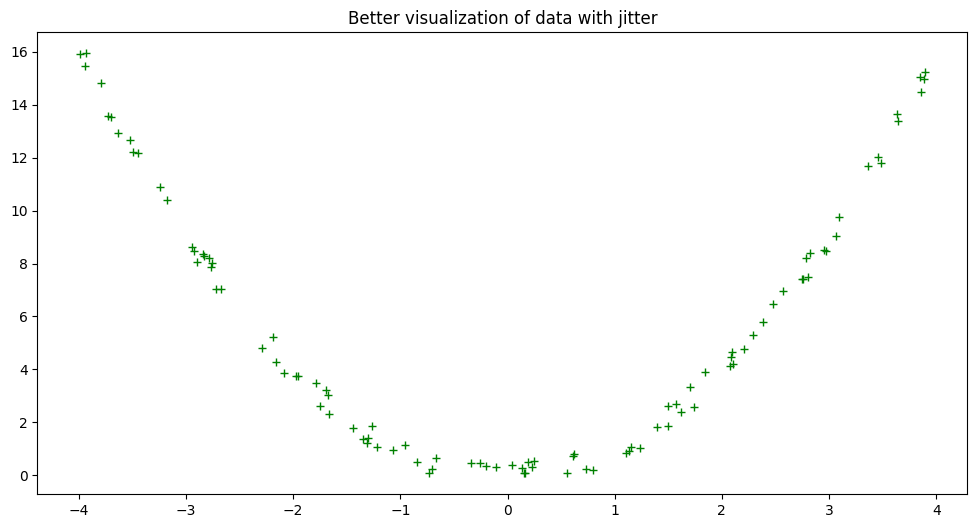

In [ ]:
# To visulaize the jitter noise added in the data
# We try to simulate another set of x and y values

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)
  
plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [ ]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.
    
    Args:
        ys: training data labels
        y_bar: prediction labels
    
    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

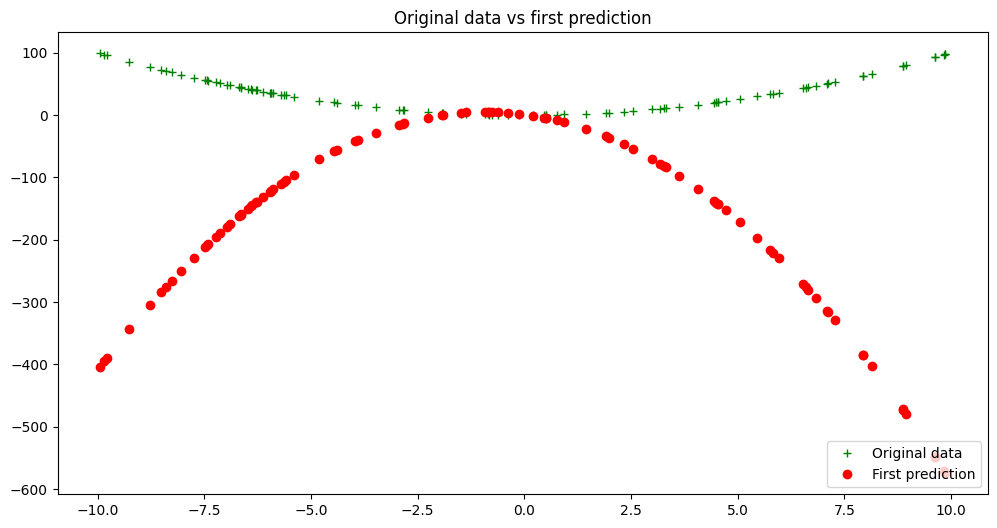

In [ ]:
# First step, randomly predicting the coefficients  
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original data')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [ ]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

76083.8796544421

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [ ]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    
    a_s = []
    b_s = []
    c_s = []
    
    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)
    
    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    # num = [i for i in y_bars]
    n = len(y_bars)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [ ]:
# Second step, finding the gradient of the problem
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0001 # learning rate

# Continuing the second step
# Changing the coeffients in the negative direction of the gradient
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new) # New coeffients
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (-2.5166532505396826, -8.960209919129737, 1.0412151227062327)
Now have smaller model loss: 27368.224018359062 vs 76083.8796544421


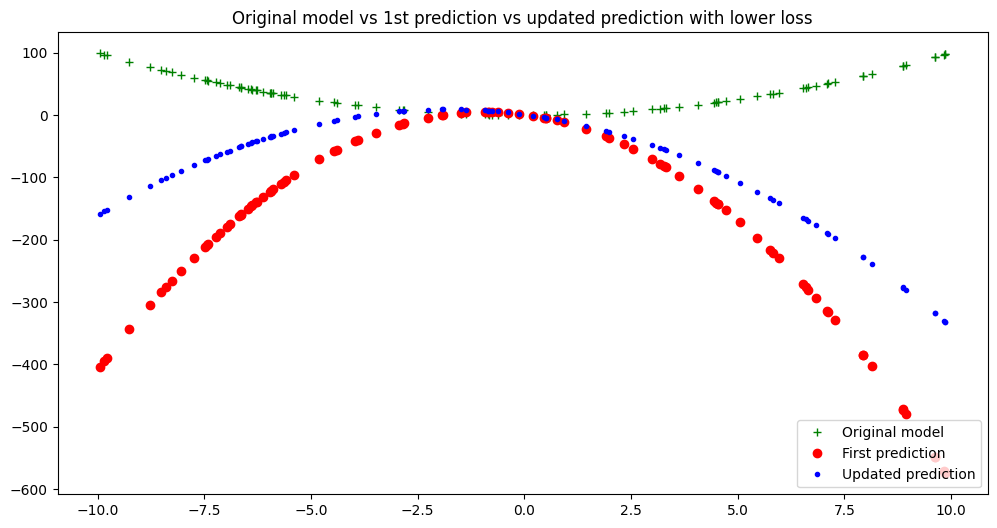

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'Original model')
plt.plot(xs, y_bar, 'ro', label = 'First prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'Updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [ ]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    """
    calculates the gradient for a second degree polynomial.
    
    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate
        
    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.
    
    """
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [ ]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.
    
    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss. 
        lr: specified learning rate
        
    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)
    
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    # Third step, Here we are fixing the number of times, we are running the problem
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

[7860.559825523337, 3008.992044463043, 2568.753953691199, 2439.575469482678, 2336.1459975874814, 2238.4531063194668, 2144.940273903798, 2055.341282855811, 1969.4862432751897, 1887.2182884471722, 1808.3875176453307, 1732.850321712146, 1660.4690935346619, 1591.1119754225747, 1524.652618765972, 1460.969953854633, 1399.9479693227127, 1341.4755008089028, 1285.4460284465094, 1231.7574828144748, 1180.312058995854, 1131.0160384050082, 1083.7796180589319, 1038.516746981699, 995.1449694440003, 953.5852747521999, 913.7619533132718, 875.6024587133999, 839.0372755589981, 803.9997928393879, 770.4261825804356, 738.2552835680924, 707.4284899300212, 677.8896443723205, 649.5849358768711, 622.4628016729309, 596.4738333043932, 571.5706866216015, 547.7079955337424, 524.8422893646978, 502.9319136618101, 481.9369543132858, 461.8191648360116, 442.54189670131177, 424.07003257172926, 406.3699223271997, 389.4093217640811, 373.1573338553646, 357.58435246505655, 342.66200841419914, 328.36311780027734, 314.66163247

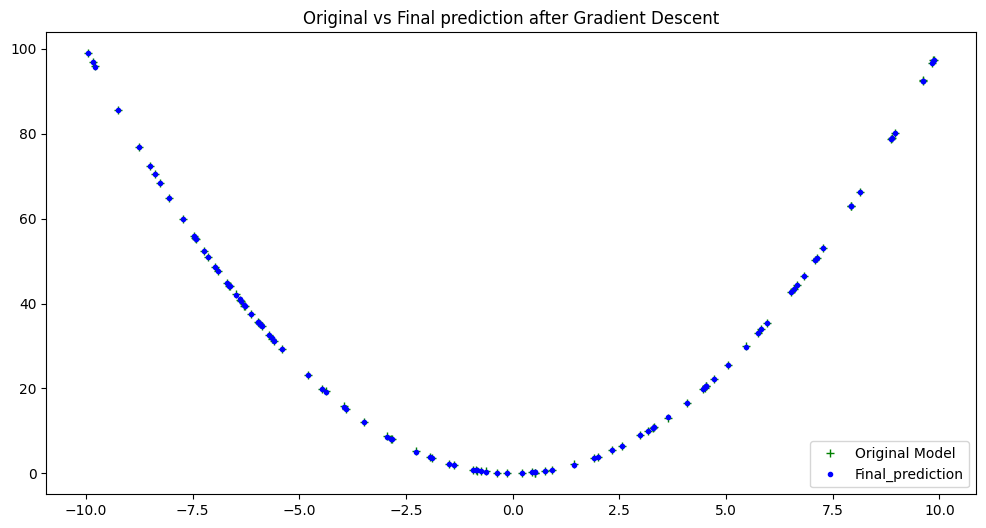

In [ ]:
GD = gradient_descent(30000, 0.0003)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9999123057971271, -0.0004965653565928932, 0.0008864451036682611)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.003834442260678742


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


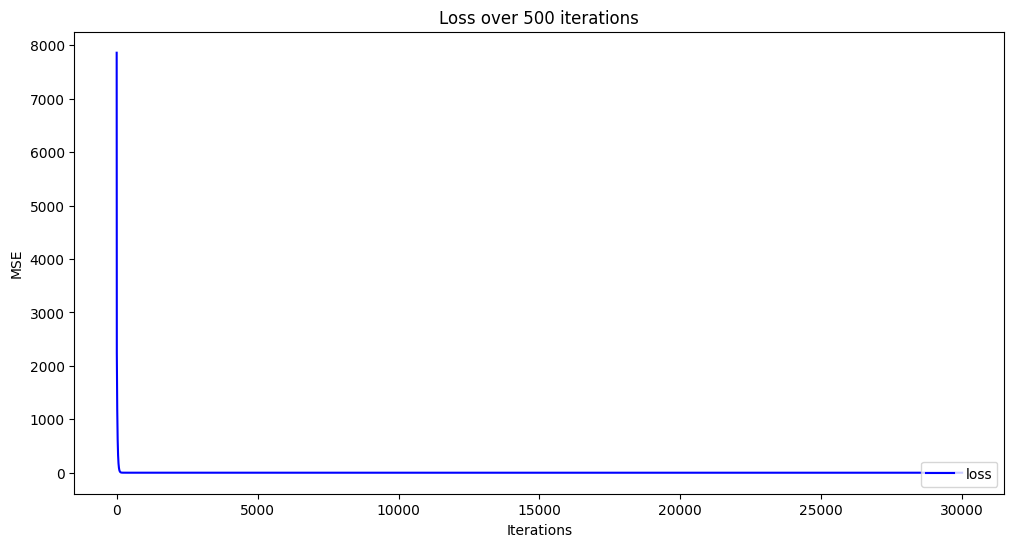

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss within about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached (another form of convergance criteria, which can be used for third step). This would prevent excessive training and potential over-fitting for the model.

NOTES:
- Please try to think on the mentioned questions first, apply on your own if possible rather than directly accessing the links. 
- But make sure, you do go through the given links at once. You can leave the discussion about the topics which are not known to you, if found difficult to understand.
<br><br>
# Things to try
1. Change the values of parameters in the functions and observe the changes in  the result.
1. Change the coefficients array and try a different polynomial instead of our $x^2$.
2. Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
  - https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/#:~:text=When%20the%20learning%20rate%20is,with%20a%20high%20training%20error.
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
  - This will help you understand the concepts of convex and non-convex optimization problems and will introduce you to the concept of local minima.
  - https://towardsdatascience.com/understand-convexity-in-optimization-db87653bf920
  - https://stats.stackexchange.com/questions/172900/can-gradient-descent-be-applied-to-non-convex-functions
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?
  - https://towardsdatascience.com/minimizing-the-cost-function-gradient-descent-a5dd6b5350e1
5. Try to compare gradient descent algorithm with your understanding on perceptron learning algorithm?
  - https://stats.stackexchange.com/questions/137834/clarification-about-perceptron-rule-vs-gradient-descent-vs-stochastic-gradient
6. Now, since we know about both SVMs and Gradient Descent. Can Gradient Descent be used in for SVM Formulation?
  - https://towardsdatascience.com/solving-svm-stochastic-gradient-descent-and-hinge-loss-8e8b4dd91f5b



#Question 1


[27368.224018359062, 11023.567489866522, 5522.577823040814, 3654.2506317468074, 3003.1144379595275, 2760.0549787773994, 2654.038696037231, 2594.2727128744987, 2550.3393477548293, 2512.044834534759, 2475.9698683250554, 2440.964447953237, 2406.638784780411, 2372.8578023065725, 2339.5718080688002, 2306.759773008727, 2274.410330917365, 2242.515412966763, 2211.0681146221136, 2180.061980284104, 2149.490762839344, 2119.348342302111, 2089.6286977582577, 2060.325897174991, 2031.4340932062796, 2002.9475210175742, 1974.8604967977399, 1947.1674165118402, 1919.8627547450772, 1892.941063587655, 1866.3969715435412, 1840.225182457296, 1814.4204744568922, 1788.9776989116665, 1763.8917794049974, 1739.1577107214189, 1714.770557847958, 1690.7254549894817, 1667.0176045978608, 1643.6422764147387, 1620.5948065277357, 1597.8705964398912, 1575.465112152159, 1553.3738832587596, 1531.5925020552345, 1510.1166226590065, 1488.9419601422728, 1468.0642896770605, 1447.4794456922762, 1427.183321042576, 1407.17186618889

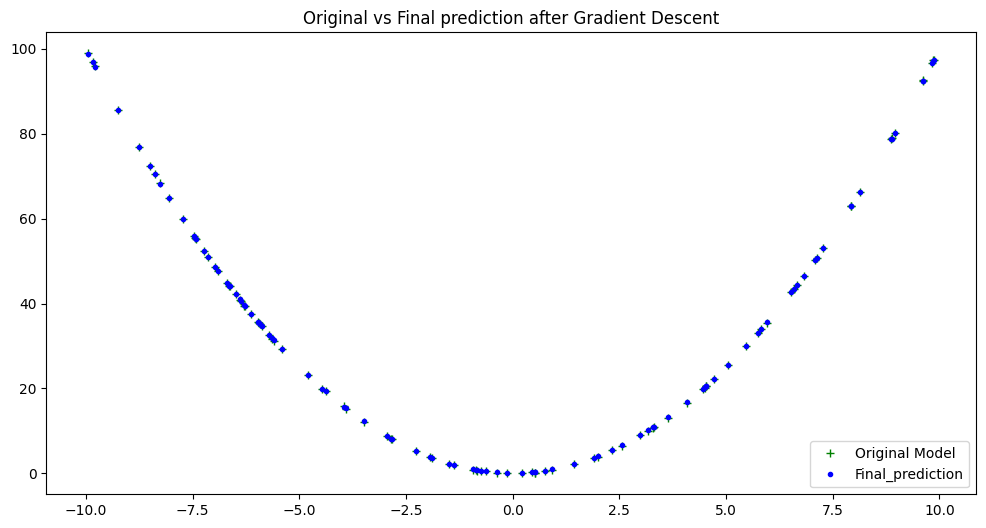

In [ ]:
GD = gradient_descent(30000,0.0001 )

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9983832123434332, 0.000138586541743205, 0.09222051912628804)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.007256223467749128


#At higher epochs

[7860.559825523337, 3008.992044463043, 2568.753953691199, 2439.575469482678, 2336.1459975874814, 2238.4531063194668, 2144.940273903798, 2055.341282855811, 1969.4862432751897, 1887.2182884471722, 1808.3875176453307, 1732.850321712146, 1660.4690935346619, 1591.1119754225747, 1524.652618765972, 1460.969953854633, 1399.9479693227127, 1341.4755008089028, 1285.4460284465094, 1231.7574828144748, 1180.312058995854, 1131.0160384050082, 1083.7796180589319, 1038.516746981699, 995.1449694440003, 953.5852747521999, 913.7619533132718, 875.6024587133999, 839.0372755589981, 803.9997928393879, 770.4261825804356, 738.2552835680924, 707.4284899300212, 677.8896443723205, 649.5849358768711, 622.4628016729309, 596.4738333043932, 571.5706866216015, 547.7079955337424, 524.8422893646978, 502.9319136618101, 481.9369543132858, 461.8191648360116, 442.54189670131177, 424.07003257172926, 406.3699223271997, 389.4093217640811, 373.1573338553646, 357.58435246505655, 342.66200841419914, 328.36311780027734, 314.66163247

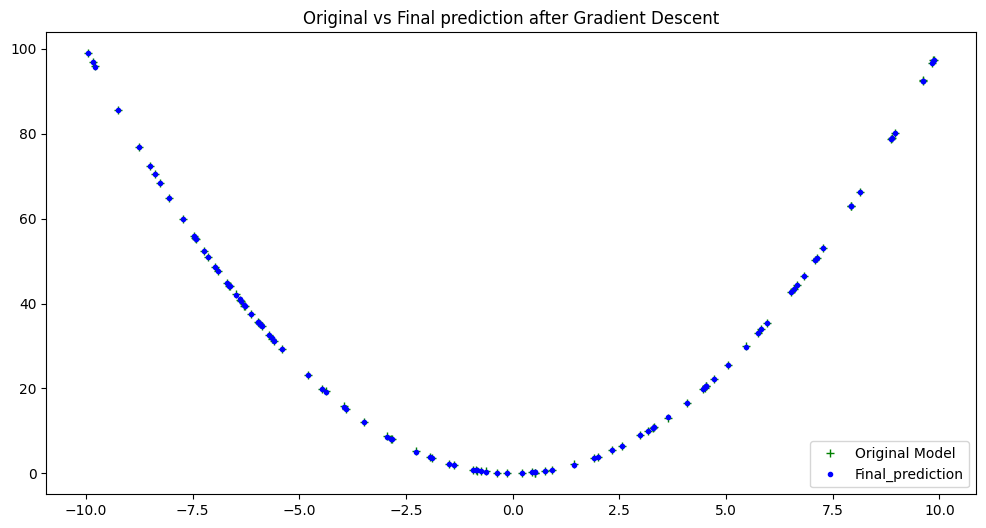

In [ ]:
GD = gradient_descent(50000,0.0003 )

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9999243408094075, -0.0005015644368504787, 0.0001675834148525503)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.003834230288632989


#At lower epochs

[7860.559825523337, 3008.992044463043, 2568.753953691199, 2439.575469482678, 2336.1459975874814, 2238.4531063194668, 2144.940273903798, 2055.341282855811, 1969.4862432751897, 1887.2182884471722, 1808.3875176453307, 1732.850321712146, 1660.4690935346619, 1591.1119754225747, 1524.652618765972, 1460.969953854633, 1399.9479693227127, 1341.4755008089028, 1285.4460284465094, 1231.7574828144748, 1180.312058995854, 1131.0160384050082, 1083.7796180589319, 1038.516746981699, 995.1449694440003, 953.5852747521999, 913.7619533132718, 875.6024587133999, 839.0372755589981, 803.9997928393879, 770.4261825804356, 738.2552835680924, 707.4284899300212, 677.8896443723205, 649.5849358768711, 622.4628016729309, 596.4738333043932, 571.5706866216015, 547.7079955337424, 524.8422893646978, 502.9319136618101, 481.9369543132858, 461.8191648360116, 442.54189670131177, 424.07003257172926, 406.3699223271997, 389.4093217640811, 373.1573338553646, 357.58435246505655, 342.66200841419914, 328.36311780027734, 314.66163247

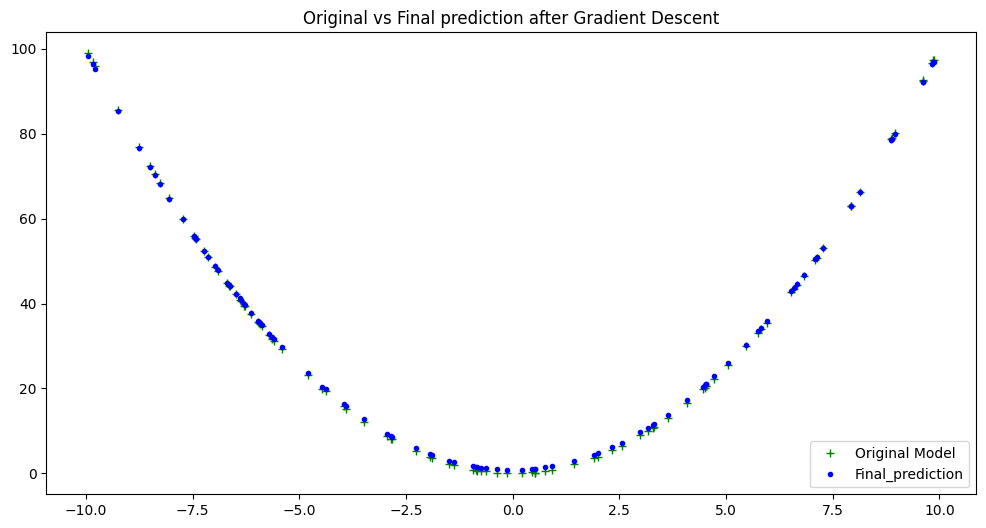

In [ ]:
GD = gradient_descent(1000,0.0003 )

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9862931553435149, 0.005160526253408236, 0.8143700738042754)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.27151734235548874


#At learning rate = 0.00001

[70043.45938464385, 64500.87802074421, 59415.0779977924, 54748.38787101728, 50466.243053965576, 46536.92958806883, 42931.349044180155, 39622.80281327351, 36586.79418723234, 33800.84676253463, 31244.337820643323, 28898.345449935834, 26745.50827587333, 24769.896759576295, 22956.89511073083, 21293.0929394351, 19766.18584379122, 18364.884196288596, 17078.829452804242, 15898.517363810784, 14815.227518549395, 13820.958699872486, 12908.369570535431, 12070.724251239053, 11301.842386988326, 10596.053331604084, 9948.154110753634, 9353.370851876041, 8807.323395078758, 8305.992822662674, 7845.6916665691415, 7423.036572893852, 7034.923220827124, 6678.503310092455, 6351.163446288884, 6050.505767612484, 5774.33016934086, 5520.617994309234, 5287.517068474077, 5073.327970631468, 4876.491434506413, 4695.576789823584, 4529.2713566720695, 4376.3707145436165, 4235.7697739077585, 4106.454584136667, 3987.494817051104, 3878.0368703672225, 3777.2975399195134, 3684.5582137514994, 3599.1595450343257, 3520.496564

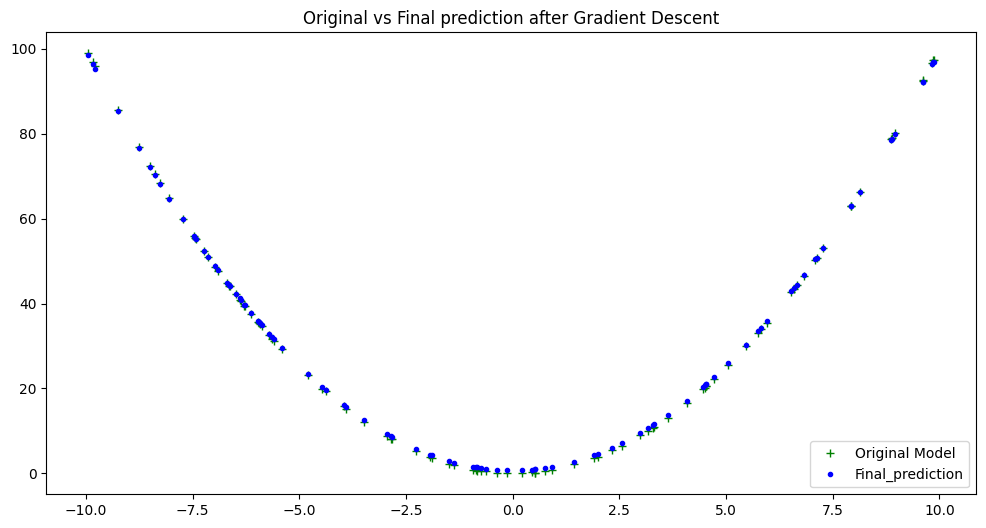

In [ ]:
GD = gradient_descent(50000,0.00001)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (0.9883252605422953, 0.004316439219371304, 0.6929906761771194)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.19765570595293486


#At learning rate = 0.0

[76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.8796544421, 76083.879

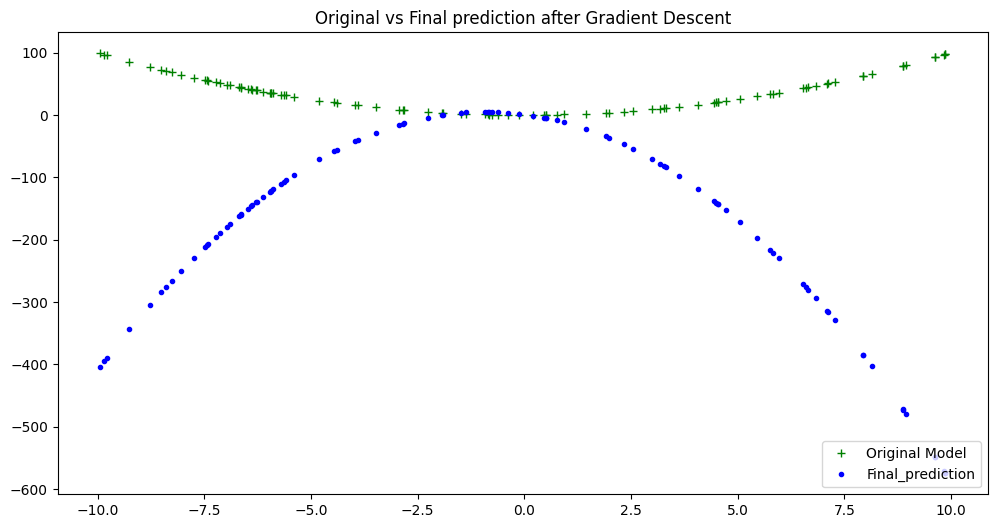

In [ ]:
GD = gradient_descent(50000,0.0)

plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'Original Model')
plt.plot(xs, GD[2], 'b.', label = 'Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (-5.0, -9.0, 1.0)
Original Coefficients: [1, 0, 0]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 76083.8796544421


#Question 2



 Updated coefficients : [3, 2, 1]  

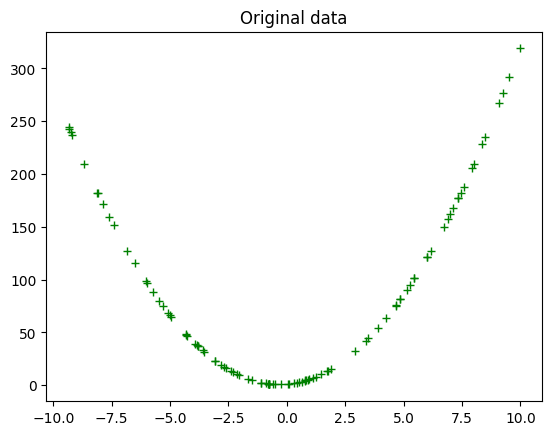

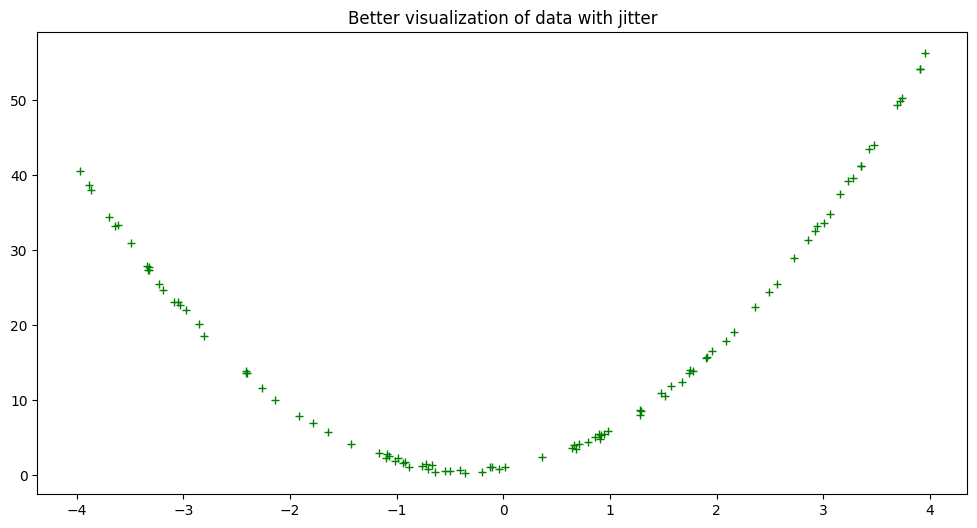

New model coeffs: (3.000008051050677, 1.999999270769908, 0.9999993266284698)
Now have smaller model loss: 0.003369488733616501 vs 76083.8796544421
[0.003368949053230526, 0.003368899691050137, 0.003368860807530598, 0.0033688226182049664, 0.003368785012585796, 0.0033687479715465178, 0.003368711477396244, 0.0033686755130178337, 0.0033686400618420983, 0.0033686051078305455, 0.003368570635457241, 0.0033685366296933566, 0.003368503075990806, 0.0033684699602672535, 0.003368437268890866, 0.00336840498866606, 0.003368373106818846, 0.003368341610985215, 0.0033683104891955506, 0.0033682797298635737, 0.0033682493217742295, 0.003368219254070354, 0.003368189516242517, 0.003368160098118203, 0.0033681309898490053, 0.003368102181902752, 0.0033680736650513383, 0.003368045430362708, 0.003368017469189498, 0.003367989773162121, 0.003367962334177317, 0.0033679351443925572, 0.003367908196214983, 0.00336788148229478, 0.0033678549955177845, 0.0033678287289966666, 0.0033678026760646652, 0.003367776830268698, 0.

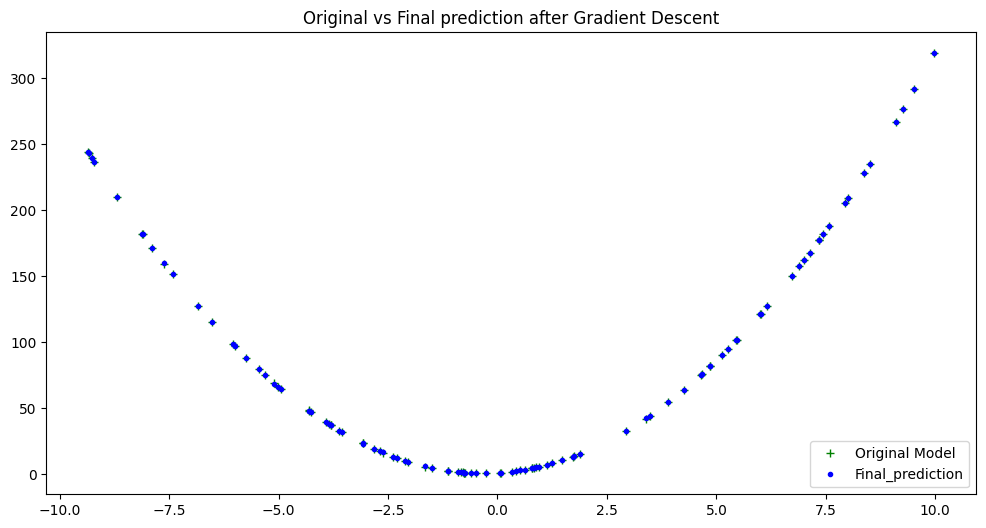

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)

def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [3, 2, 1]  # Updated coefficients

xs = []
ys = []
for x in hundred_xs:
    y = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max  # Generate a random number in range 0 to interval max

    while interval_min > jit_val:  # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
        # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


# To visualize the jitter noise added in the data
# We try to simulate another set of x and y values

hundred_xt = np.random.uniform(-4, 4, 100)
xt = []
yt = []

for x in hundred_xt:
    y = eval_2nd_degree_jitter(coeffs, x, 0.5)
    xt.append(x)
    yt.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xt, yt, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()

def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)


def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):  # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    # num = [i for i in y_bars]
    n = len(y_bars)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)  # return calculated gradients as a tuple of its 3 parts


# Second step, finding the gradient of the problem
calc_grad = calc_gradient_2nd_poly(coeffs, hundred_xs, ys)

lr = 0.0001  # learning rate

# Continuing the second step
# Changing the coefficients in the negative direction of the gradient
a_new = coeffs[0] - lr * calc_grad[0]
b_new = coeffs[1] - lr * calc_grad[1]
c_new = coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new)  # New coefficients
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x, y, y_bar in list(zip(inputs_x, outputs_y, y_bars)):  # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar


def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updating loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    coeffs_to_test = coeffs

    # Third step, Here we are fixing the number of times, we are running the problem
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(coeffs_to_test, hundred_xs, ys, lr)
        coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)

    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)


GD = gradient_descent(30000, 0.0003)

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label='Original Model')
plt.plot(xs, GD[2], 'b.', label='Final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc="lower right")
plt.show()


In [ ]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")
print()
print(f"Initial Loss Calculated: {initial_model_loss}")
print(f"Loss calculated after last epoch: {GD[3][-1]}")

Final Coefficients predicted: (3.0001744364481344, 1.9997828221471998, 0.9919275021453756)
Original Coefficients: [3, 2, 1]

Initial Loss Calculated: 76083.8796544421
Loss calculated after last epoch: 0.003335053542775567


#Question 3


In [ ]:
import numpy as np

def eval_5th_degree(coeffs, x):
    """
    Function to return the output of evaluating a fifth degree polynomial,
    given a specific x value.
    
    Args:
        coeffs: List containing the coefficients a, b, c, d, e, and f for the polynomial.
        x: The input x value to the polynomial.
    
    Returns:
        y: The corresponding output y value for the fifth degree polynomial.
    
    """
    a = coeffs[0] * (x ** 5)
    b = coeffs[1] * (x ** 4)
    c = coeffs[2] * (x ** 3)
    d = coeffs[3] * (x ** 2)
    e = coeffs[4] * x
    f = coeffs[5]
    y = a + b + c + d + e + f
    return y



In [ ]:

def eval_5th_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a fifth degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].
    
    Args:
        coeffs: List containing the coefficients a, b, c, d, e, and f for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.
    
    Returns:
        y: The corresponding jittered output y value for the fifth degree polynomial.
    
    """

    a = coeffs[0] * np.power(x,5)
    b = coeffs[1] * np.power(x,4)
    c = coeffs[2] * np.power(x,3)
    d = coeffs[3] * np.power(x,2)
    e = coeffs[4] * np.power(x,1)
    f = coeffs[5]
    y = a + b + c + d + e + f
    
    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max 
    
    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it 
                                                  # give a number greater than the interval min. 
    
    return jit_val
     


In [ ]:
def calc_gradient_5th_poly(rand_coeffs, hundred_xs, ys): 
    """
    Calculates the gradient for a fifth degree polynomial.
    
    Args:
        rand_coeffs: List containing the coefficients a, b, c, d, e, and f for the polynomial.
        hundred_xs: List of x input datapoints.
        ys: List of actual y output points.
        
    Returns: 
        Calculated gradients for the fifth degree polynomial, as a tuple of its parts for a, b, c, d, e, and f respectively.
    
    """
    
    gradient_parts = [0] * len(rand_coeffs)  # Initialize a list to store the partial gradients
    
    y_bars = eval_5th_degree(rand_coeffs, hundred_xs)  # Calculate the predicted y values
    
    for x, y, y_bar in zip(hundred_xs, ys, y_bars):
        powers_of_x = [x ** (len(rand_coeffs) - i - 1) for i in range(len(rand_coeffs))]  # Calculate the powers of x
        partial_gradients = [(y - y_bar) * power for power in powers_of_x]  # Calculate the partial gradients
        gradient_parts = [g + p for g, p in zip(gradient_parts, partial_gradients)]  # Sum the partial gradients
    
    n = len(y_bars)
    gradients = [-2 * p / n for p in gradient_parts]  # Scale the gradients by -2/n
    
    return tuple(gradients)  # Return the calculated gradients as a tuple

# # Usage:
# hundred_xs = np.random.uniform(-10, 10, 100)
# coeffs = np.random.uniform(-10, 10, 6)
# ys = [eval_5th_degree(coeffs, x) for x in hundred_xs]

# gradients = calc_gradient_5th_poly(coeffs, hundred_xs, ys)


In [ ]:
def calc_gradient_5th_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
    d_s = []
    e_s = []
    f_s = []
        
    y_bars = eval_5th_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)       
        partial_a = (x ** 5) * (y - y_bar)
        a_s.append(partial_a)
        partial_b = (x ** 4) * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (x ** 3) * (y - y_bar)
        c_s.append(partial_c)
        partial_d = (x ** 2) * (y - y_bar)
        d_s.append(partial_d)
        partial_e = (x ** 1) * (y - y_bar)
        e_s.append(partial_e)
        partial_f = (y - y_bar)
        f_s.append(partial_f)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)
    gradient_d = (-2 / n) * sum(d_s)
    gradient_e = (-2 / n) * sum(e_s)
    gradient_f = (-2 / n) * sum(f_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    d_new = coeffs[3] - lr * gradient_d
    e_new = coeffs[4] - lr * gradient_e
    f_new = coeffs[5] - lr * gradient_f
    
    new_model_coeffs = (a_new, b_new, c_new, d_new, e_new, f_new)
    
    # update with these new coeffs:
    new_y_bar = eval_5th_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [ ]:
def gradient_descent(epochs, lr, rand_coeffs):
    """
    Perform gradient descent for a fifth degree polynomial.
    
    Args:
        epochs: Number of iterations to perform for finding new coefficients and updating the loss.
        lr: Specified learning rate.
        
    Returns:
        Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates).
    
    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    
    for i in range(epochs):
        loss = calc_gradient_5th_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)


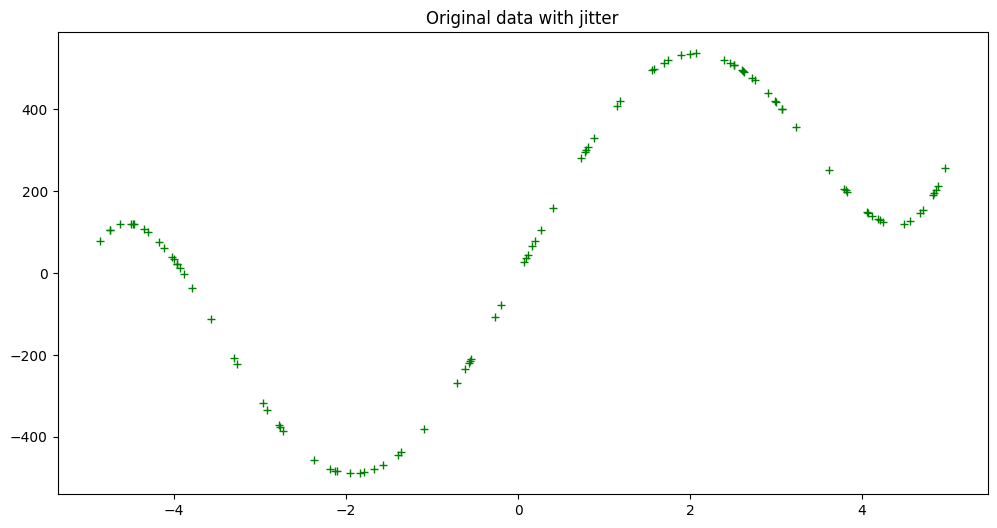

In [ ]:

hundred_xs = np.random.uniform(-5, 5, 100)
coeffs = [1, 0, -40, 6,400 , 0]


xs = []
ys = []
for x in hundred_xs:
    y  = eval_5th_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()    


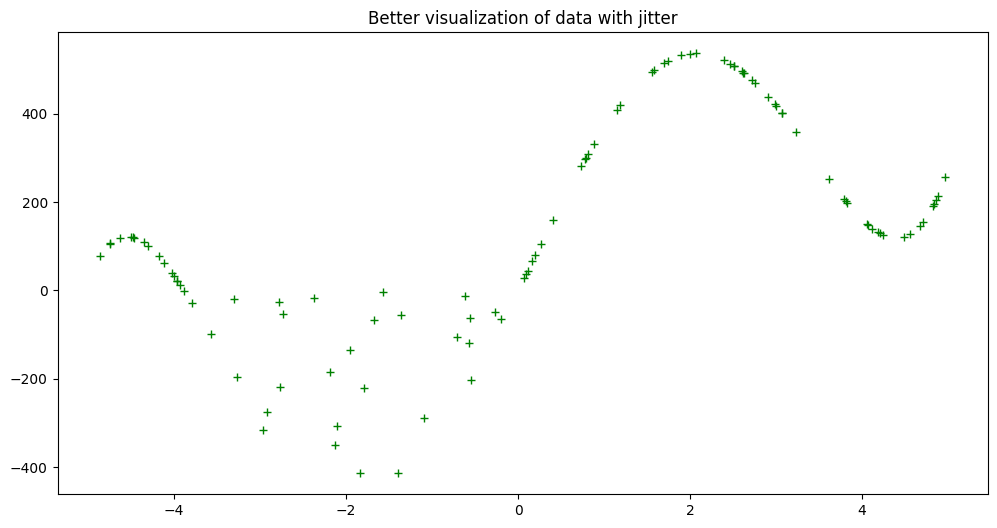

In [ ]:

xs = []
ys = []
for x in hundred_xs:
    y  = eval_5th_degree_jitter(coeffs, x, 0.5)
    xs.append(x)
    ys.append(y)

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Better visualization of data with jitter')
plt.show()  

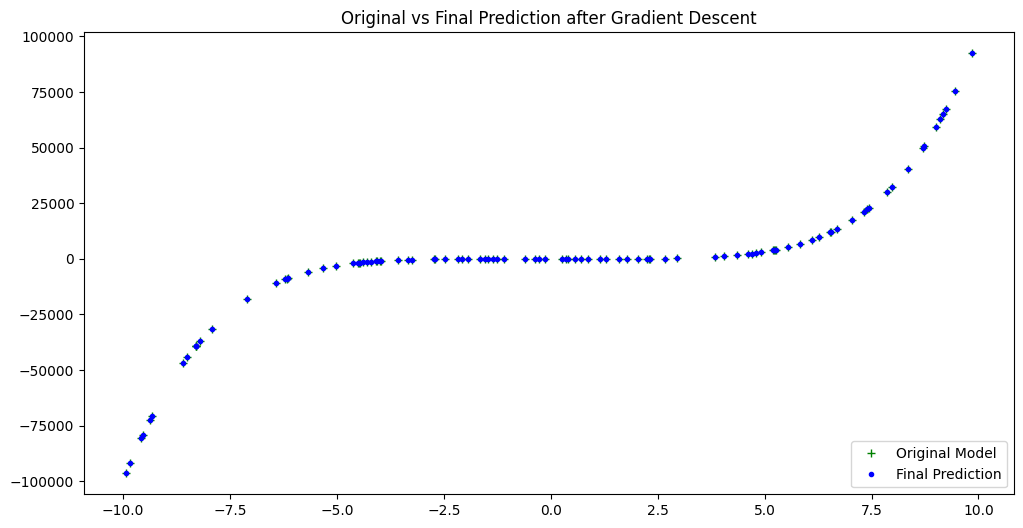

In [ ]:
hundred_xs = np.random.uniform(-10, 10, 100)

# Set the coefficients for the 5th degree polynomial
rand_coeffs = [1, 0, 0, 0, 0, 0]

# Generate y values using the 5th degree polynomial
ys = [eval_5th_degree(rand_coeffs, x) for x in hundred_xs]

GD = gradient_descent(30000, 0.0003,rand_coeffs)

# Visualize the original and final predictions
plt.figure(figsize=(12, 6))
plt.plot(hundred_xs, ys, 'g+', label='Original Model')
plt.plot(hundred_xs, GD[2], 'b.', label='Final Prediction')
plt.title('Original vs Final Prediction after Gradient Descent')
plt.legend(loc="lower right")
plt.show()

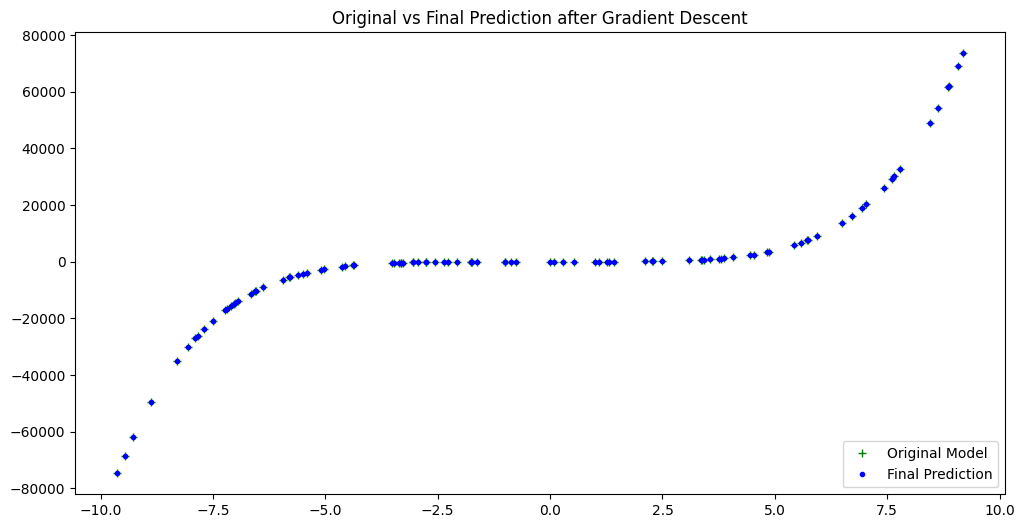

In [ ]:
hundred_xs = np.random.uniform(-10, 10, 100)

# Set the coefficients for the 5th degree polynomial
rand_coeffs = [1, 1, 1, 3, 4, -1]

# Generate y values using the 5th degree polynomial
ys = [eval_5th_degree(rand_coeffs, x) for x in hundred_xs]

GD = gradient_descent(30000, 0.0003,rand_coeffs)

# Visualize the original and final predictions
plt.figure(figsize=(12, 6))
plt.plot(hundred_xs, ys, 'g+', label='Original Model')
plt.plot(hundred_xs, GD[2], 'b.', label='Final Prediction')
plt.title('Original vs Final Prediction after Gradient Descent')
plt.legend(loc="lower right")
plt.show()



#Question 5


Yes, the algorithm to find a maxima of a function, instead of a minima.
It can be achieved by multiplying the gradient by a positive constant, which effectively changes the direction of the update.
Move in the opposite direction by subtracting this from the initial guess. This is because we want to descend and gradient gives you steepest ascent direction.

#Question 6

1. **Primary aim :**

    * Gradient Descent: GD minimizes a given cost function by iteratively updating the parameters in the direction of steepest descent of the cost function's gradient.

    * Perceptron Learning: It finds a decision boundary that separates two classes of data points.


2. **Convergence:**

    * Gradient Descent: The convergence of GD depends on factors such as the learning rate, the choice of optimization algorithm (e.g., batch, stochastic, mini-batch), and the characteristics of the cost function. It aims to converge to a local minimum of the cost function.

    * Perceptron algorithm: It converges if the classes are linearly separable.The learning process can be limited to a maximum number of iterations.

3. **Learning Rule:**

    * Gradient Descent: It involves updating the parameters in the direction of the negative gradient of the cost function. The magnitude of the update is determined by the learning rate.

     It is used for optimizing parameters (coefficients) in various models by iteratively updating them based on the gradients of the cost function with respect to the parameters.

    * Perceptron Learning: It updates the weights based on the misclassified data points. The update is proportional to the input values of the misclassified points.

    It optimizes the weights of a linear model, specifically a single-layer perceptron, in order to classify input data points into two classes.

4. **Usage:**
   
    * Gradient Descent: It is a widely used optimization algorithm and is applied in ML models, such as linear regression, logistic regression, neural networks, and support vector machines (SVM).

    * Perceptron Learning: It is designed for binary classification problems and is used for pattern recognition and binary image classification.

#Question 7


Yes, Gradient Descent be used in for SVM Formulation.
In SVM formulation, the parameters to be optimized are the weights assigned to the features and the bias term. It involves finding the parameters that minimize a specific objective function, typically a combination of the margin and the regularization term.

Here, GD can be employed to solve the optimization problem i.e.  converge towards the optimal parameter values (in direction of the negative gradient of the objective function).

Source : https://users.cs.utah.edu/~zhe/pdf/lec-19-2-svm-sgd-upload.pdf

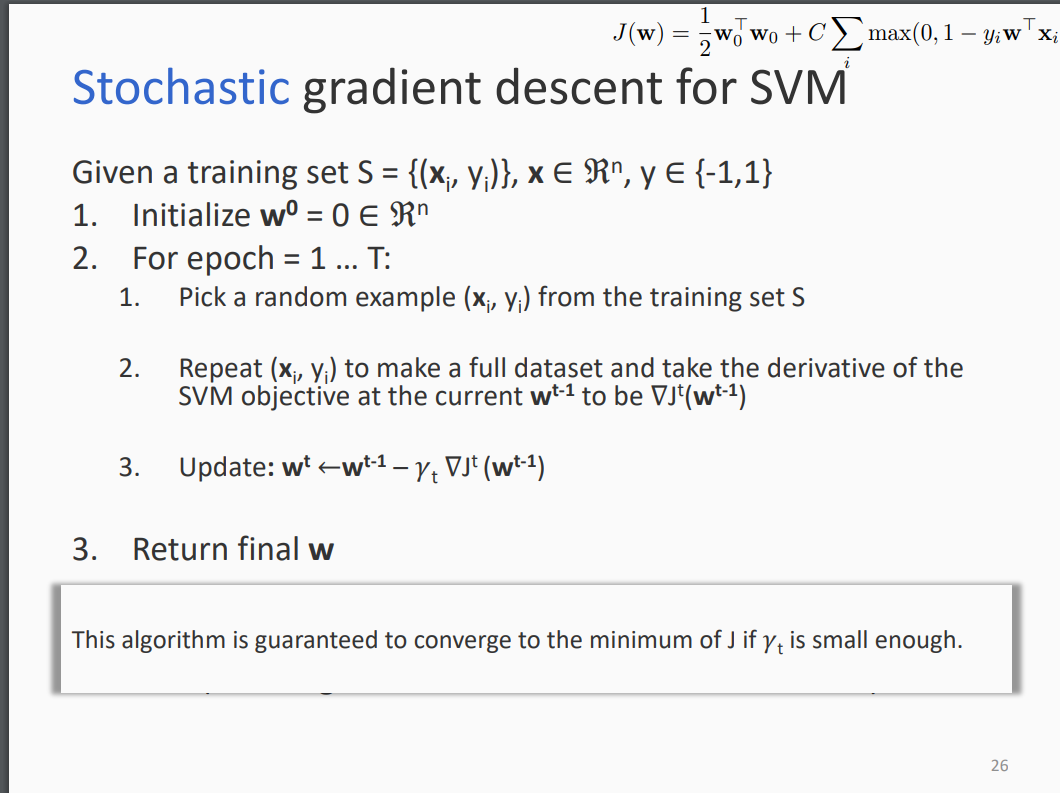